<a href="https://colab.research.google.com/github/jubakala/hockey-predictor-java/blob/master/TamiPrinciple_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Phase I


**First, let's explore the relationship between goalie's win percentage and save percentage, and win percentage and goals against average.**


In [4]:
df = pd.read_csv('goalies.csv')

In [5]:
df.head()

,Season,Team,Player,Saves,Shots,Conceded,Matches,TOC,Wins,Save%,GA,Win%
0,1997-1998,PIT,Tom Barrasso,1203,1293,90,47,172473,22,93.04,1.88,45.92
1,1997-1998,LAK,Stephane Fiset,1339,1471,132,50,182341,22,91.03,2.61,43.44
2,1997-1998,PHI,Ron Hextall,781,860,79,35,127669,14,90.81,2.23,39.48
3,1997-1998,FLA,John Vanbiesbrouck,1252,1379,127,49,178976,15,90.79,2.55,30.17
4,1997-1998,MTL,Andy Moog,769,840,71,32,116615,14,91.55,2.19,43.22


**Let's take into account only goalies that have played at least 20 matches.**

In [6]:
filtered = df[df['Matches'] > 19]

**There doesn't seem to be very strong correlation between the goalies save percentage and his win percentage.**

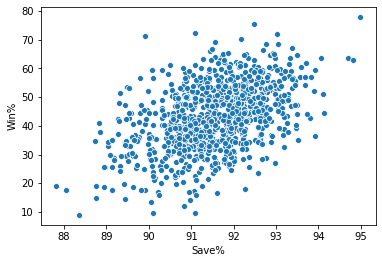

In [7]:
sns.scatterplot(x='Save%', y='Win%', data=filtered)

**The correlation between goals against average and win percent is a little bit stronger and clearer.**

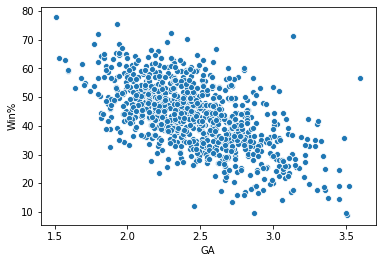

In [8]:
sns.scatterplot(x='GA', y='Win%', data=filtered)

**Let's use linear regression to explore more the relationship between goals against average and win percentage.**

In [9]:
X = filtered.iloc[:, 10:11].values
y = filtered.iloc[:, -1].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [11]:
X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [12]:
regressor = LinearRegression()

In [13]:
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
y_pred = regressor.predict(X_test)

**There clearly seems to be a negative relationship between the goals against average and win percentage. The smaller the GA, the bigger the win percentage. Although, there are a lot of outliers, a trend can be seen the plot.**

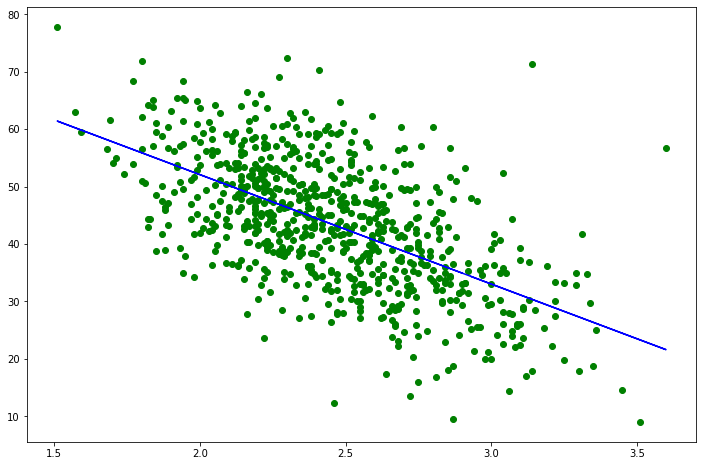

In [15]:
# Training dataset.
plt.figure(figsize=(12,8))
plt.scatter(X_train, y_train, color='green')
plt.plot(X_train, regressor.predict(X_train), color='blue')
plt.show()

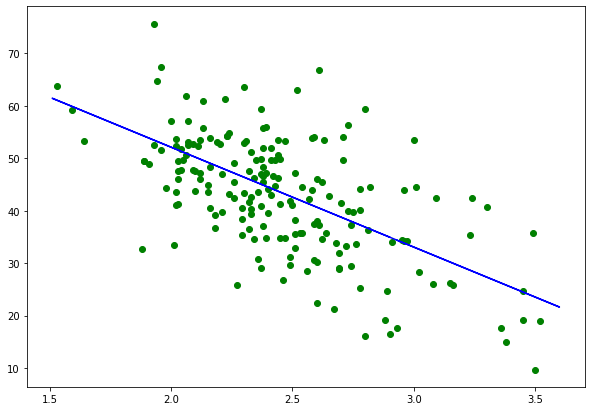

In [16]:
# Test set.
plt.figure(figsize=(10,7))
plt.scatter(X_test, y_test, color='green')
plt.plot(X_train, regressor.predict(X_train), color='blue')
plt.show()

**Let's test how both goals against average and save percentage correlate to the win percentage using multilinear regression.**

In [17]:
filtered.head()

,Season,Team,Player,Saves,Shots,Conceded,Matches,TOC,Wins,Save%,GA,Win%
0,1997-1998,PIT,Tom Barrasso,1203,1293,90,47,172473,22,93.04,1.88,45.92
1,1997-1998,LAK,Stephane Fiset,1339,1471,132,50,182341,22,91.03,2.61,43.44
2,1997-1998,PHI,Ron Hextall,781,860,79,35,127669,14,90.81,2.23,39.48
3,1997-1998,FLA,John Vanbiesbrouck,1252,1379,127,49,178976,15,90.79,2.55,30.17
4,1997-1998,MTL,Andy Moog,769,840,71,32,116615,14,91.55,2.19,43.22


In [18]:
filtered = filtered.drop(['Season', 'Team','Player', 'Saves', 'Shots','Conceded', 'Matches', 'TOC', 'Wins'], axis=1)

In [19]:
filtered.head()

,Save%,GA,Win%
0,93.04,1.88,45.92
1,91.03,2.61,43.44
2,90.81,2.23,39.48
3,90.79,2.55,30.17
4,91.55,2.19,43.22


In [20]:
X = filtered.iloc[:, :-1].values
y = filtered.iloc[:, -1].values

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [22]:
multi_regressor = LinearRegression()

In [23]:
multi_regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**It can be seen that the save percentage doesn't have a strong correlation with win percentage, where as similar negative correlation compared to the simple linear regression showed for the goals against average.**

In [24]:
print(multi_regressor.coef_)

[  0.1197213  -18.76478454]


# Phase II

**Next, let's explore the relationship goalie's save percentage and goals against average (ga), *prior* to a single match, to the outcome of the match. Ie. let's try to explore, if the goalies with better save percentage/ga win more matches than the goalies with worse stats.**

In [27]:
match_data = pd.read_csv('all_matches_with_avgs.csv')

**Let's create a new variable 'match_goal_diff'. It is the goal difference of a single match. If it's negative, away team won, if positive, home team won. If the difference is zero, the match ended as draw, after the extra time.**

In [28]:
match_data['match_goal_diff'] = match_data['home_goals'] - match_data['away_goals']

**Let's create two more variables for save percentage differerence between the starting goalies and for the ga difference between the goalies.**

In [29]:
match_data['save_percentage_diff'] = round(match_data['home_save_percentage'] - match_data['away_save_percentage'], 2)
match_data['ga_diff'] = round(match_data['home_ga'] - match_data['away_ga'], 2)

In [36]:
# These function determines, if the better goalie's team won the match.
# Better by save percentage.
def check_save_perc_wins(match):
  if match['match_goal_diff'] < 0 and match['save_percentage_diff'] < 0: # Away win.
    return 1
  elif match['match_goal_diff'] > 0 and match['save_percentage_diff'] > 0:
    return 1
  else:
    return 0

# Better by goals against average.
def check_ga_wins(match):
  if match['match_goal_diff'] < 0 and match['ga_diff'] > 0: # Away win.
    return 1
  elif match['match_goal_diff'] > 0 and match['ga_diff'] < 0:
    return 1
  else:
    return 0

**Let's calculate, how many times the better goalie's team actually won, according to save percentage and ga.**

In [37]:
match_data['better_goalie_won_save_perc'] = match_data.apply(check_save_perc_wins, axis=1)
match_data['better_goalie_won_ga'] = match_data.apply(check_ga_wins, axis=1)

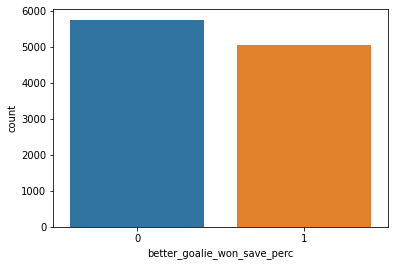

In [39]:
sns.countplot(match_data['better_goalie_won_save_perc'])

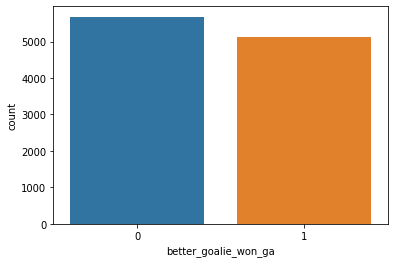

In [40]:
sns.countplot(match_data['better_goalie_won_ga'])

**The problem with both of the calculations is that the goalie is considered better whether the save percentage/ga difference between the goalies is 0.01 or 5.00 units. So, first instead of just calculating the differences between save percentages and gas, let's calculate their distance from each other, and then let's get the means of those distances.**

In [50]:
# This function calculates the distance between the goalies' save percentages.
def save_perc_distance(match):
  diff = match['home_save_percentage'] - match['away_save_percentage']
  return round(np.sqrt(diff * diff), 2)

# This function calculates the distance between the goalies' goals against averages.
def ga_distance(match):
  diff = match['home_ga'] - match['away_ga']
  return round(np.sqrt(diff * diff), 2)

In [51]:
match_data['save_perc_distance'] = match_data.apply(save_perc_distance, axis=1)
match_data['ga_distance'] = match_data.apply(ga_distance, axis=1)

**Let's calculate the means of save percentage distance and ga distance.**

In [53]:
save_perc_distance_mean = match_data['save_perc_distance'].mean()
ga_distance_mean = match_data['ga_distance'].mean()
print(save_perc_distance_mean, ga_distance_mean)

1.625876479289938 0.5171301775147985


**Now that we know that the mean distance of save percentages is 1.6 and goals against averages is 0.52, let's use them to define which goalie is actually better. So, if either of the values is smaller than the mean, let's omit those matches.**

In [54]:
ga_differs = match_data[match_data['ga_diff'] >= 0.5]
save_perc_differs = match_data[match_data['save_perc_diff'] >= 1.6]

In [55]:
print(len(ga_differs), len(save_perc_differs))

2164 4334


**It seems that using the means as a separator for a better goalie is a little bit to big, so let's try other values as well.**

In [57]:
ga_differs_0_4 = match_data[match_data['ga_diff'] >= 0.4]
save_perc_differs_1_4 = match_data[match_data['save_perc_diff'] >= 1.4]
ga_differs_0_3 = match_data[match_data['ga_diff'] >= 0.3]
save_perc_differs_1_3 = match_data[match_data['save_perc_diff'] >= 1.3]
ga_differs_0_25 = match_data[match_data['ga_diff'] >= 0.25]
save_perc_differs_1_25 = match_data[match_data['save_perc_diff'] >= 1.25]

print("GA 0.4, Save % 1.4")
print(len(ga_differs_0_4), len(save_perc_differs_1_4))
print("GA 0.3, Save % 1.3")
print(len(ga_differs_0_3), len(save_perc_differs_1_3))
print("GA 0.25, Save % 1.25")
print(len(ga_differs_0_25), len(save_perc_differs_1_25))

GA 0.4, Save % 1.4
2662 4948
GA 0.3, Save % 1.3
3261 5279
GA 0.25, Save % 1.25
3551 5452


**Means of 0.3 for GA and 1.3 for save percentage seems to be a good middle ground to have enough data for comparison.**

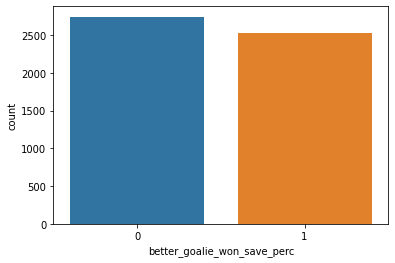

In [58]:
sns.countplot(save_perc_differs_1_3['better_goalie_won_save_perc'])

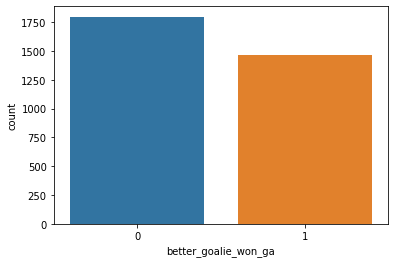

In [59]:
sns.countplot(ga_differs_0_3['better_goalie_won_ga'])

**As we can see, just by watching the countplots, at least when tested on a very rudimentary level, the claim that "if there is difference between the goalies, the better goalie's team will win" is incorrect.**